# 0-D Solid Rocket Motor (SRM) Model — Extended Derivation

This notebook implements an extended **zero-dimensional (0-D)** internal ballistics model for a solid rocket motor that includes:

1. **Saint-Robert burn law** for propellant regression  
2. **Non-cylindrical grain geometry** via a tabulated function of web regression  
3. **Nozzle throat erosion**  
4. **Non-adiabatic wall heat losses**  
<span style="color:red">5. **Explicit combustion heat release**</span>  
<span style="color:red">6. **Igniter mass injection and heat input**</span>  
<span style="color:red">7. A smooth **transition from ignition to equilibrium** via an ignition ramp function</span>

The model is formulated as an ODE system for `scipy.integrate.solve_ivp`.

---

## 1. Control Volume and Assumptions

Control volume: **gas in the chamber**.

- Chamber pressure: $p(t)$  
- Chamber temperature: $T(t)$  
- Gas mass: $m(t)$  
- Chamber free volume: $V(t)$ (depends on grain regression $s(t)$)  
- Propellant regression distance: $s(t)$  
- Nozzle throat radius: $r_t(t)$  

Mass flows:

- $\dot m_b(t)$: mass produced by propellant burning  
- $\dot m_e(t)$: mass exiting through nozzle  
- $\dot m_{\text{ign}}(t)$: igniter gas mass injection  

Heat terms:

- $\dot Q_{\text{wall}}(t)$: wall heat loss  
- $\dot Q_{\text{comb}}(t)$: combustion heat release from main propellant  
- $\dot Q_{\text{ign}}(t)$: heat release from igniter  

Total heat to gas:

$$
\dot Q = \dot Q_{\text{wall}} + \dot Q_{\text{comb}} + \dot Q_{\text{ign}}.
$$

Assumptions:

- Gas is **well-mixed** (0-D model): uniform $p(t), T(t)$.  
- Ideal gas with constant $R, c_p, c_v$, $\gamma = c_p/c_v$.  
- No shaft work, negligible kinetic and potential energy in CV.  

---

## 2. Mass and Energy Balances

### 2.1 Mass Balance

Total gas mass in the chamber evolves as:

$$
\boxed{
\frac{dm}{dt} = \dot m_b + \dot m_{\text{ign}} - \dot m_e
}
$$

---

### 2.2 Energy Balance (with combustion & igniter heat)

Total internal energy:

$$
U = m u = m c_v T.
$$

Unsteady first law:

$$
\frac{d}{dt}(m c_v T)
= \dot m_b h_b + \dot m_{\text{ign}} h_{\text{ign}} - \dot m_e h_e
 - p \frac{dV}{dt} + \dot Q_{\text{wall}} + \dot Q_{\text{comb}}^{\text{chem}}.
$$

To keep things simple and avoid double counting, we:

- Approximate inflow/outflow enthalpies with $h_b \approx h_e \approx c_p T$, $h_{\text{ign}} \approx c_p T_{\text{ign}}$.  
- Represent **combustion chemical heat release** through a **per-unit-mass** term:

$$
\dot Q_{\text{comb}} = \dot m_b \Delta h_c
$$

where $\Delta h_c$ is the effective heat of combustion (J/kg) of the propellant.

Collecting all heat terms:

$$
\dot Q = \dot Q_{\text{wall}} + \dot Q_{\text{comb}} + \dot Q_{\text{ign}},
$$

with $\dot Q_{\text{ign}}$ optionally included via igniter enthalpy if desired.  
In the final pressure equation we just use the **net** $\dot Q$.

Proceeding with the standard derivation (treating inflow/outflow enthalpies as $c_p T$) leads to the same **structural form** for the pressure equation, but now with an augmented $\dot Q$:

$$
\boxed{
\frac{dp}{dt}
= \gamma p\left[
\frac{\dot m_b + \dot m_{\text{ign}} - \dot m_e}{m}
 - \frac{1}{V}\frac{dV}{dt}
\right]
+ \frac{\gamma - 1}{V}\dot Q
}
$$

where

- $\dot Q = \dot Q_{\text{wall}} + \dot Q_{\text{comb}} + \dot Q_{\text{ign}}$  
- $\dot Q_{\text{comb}} = \dot m_b \Delta h_c$  
- $\dot Q_{\text{wall}} = -h_w A_w(s)(T - T_w)$  

---

## 3. Ideal Gas Law

The chamber gas obeys:

$$
p V = m R T
\quad\Rightarrow\quad
T = \frac{p V}{m R}.
$$

We use this at each time step.

---

## 4. Saint-Robert Burn Law with Ignition Ramp

Base Saint-Robert law:

$$
r_b^{\text{base}} = a\,p^n.
$$

To model **transition from ignition to equilibrium**, introduce an **ignition ramp function** $f_{\text{ign}}(t)$:

- $f_{\text{ign}}(t) \approx 0$ before/just after ignition
- $f_{\text{ign}}(t) \to 1$ as the grain is fully ignited

For example, a simple exponential ramp:

$$
f_{\text{ign}}(t) =
\begin{cases}
0, & t < t_{\text{ign,start}} \\
1 - \exp\!\left(-\dfrac{t - t_{\text{ign,start}}}{\tau_{\text{ign}}}\right), & t \ge t_{\text{ign,start}}
\end{cases}
$$

Then the **effective burn rate** is:

$$
\boxed{
r_b(t) = f_{\text{ign}}(t)\,a\,p^n
}
$$

Mass generation by propellant:

$$
\boxed{
\dot m_b = \rho_p \, r_b(t) \, A_b(s)
}
$$

where $A_b(s)$ is burning area as a function of web $s$.

The **web regression ODE**:

$$
\boxed{
\frac{ds}{dt} = r_b(t)
}
$$

---

## 5. Non-Cylindrical Grain Geometry (via $s$)

We represent arbitrary grain shapes by precomputing:

- $A_b(s)$: burning area vs web regression  
- $V(s)$: free volume vs web regression  

and numerically differentiating to get:

- $\dfrac{dV}{ds}(s)$

Then:

$$
\frac{dV}{dt} = \frac{dV}{ds}(s) \frac{ds}{dt}
= \frac{dV}{ds}(s)\,r_b(t).
$$

We approximate wall area as $A_w(s) \approx A_b(s)$ for heat loss.

---

## 6. Nozzle Flow and Throat Erosion

### 6.1 Choked Nozzle Flow

Throat area:

$$
A_t = \pi r_t^2.
$$

Choked mass flow:

$$
\boxed{
\dot m_e
= C_d A_t p\sqrt{\frac{\gamma}{R T}}
\left(\frac{2}{\gamma+1}\right)^{\frac{\gamma+1}{2(\gamma -1)}}
}
$$

### 6.2 Nozzle Throat Erosion

Simple erosion model:

$$
\boxed{
\frac{dr_t}{dt} = k_{\text{eros}}\left|\dot m_e\right|
}
$$

---

## 7. Igniter Mass Injection and Heat Release

We define an **igniter mass flow** $\dot m_{\text{ign}}(t)$, for example as a decaying exponential:

$$
\dot m_{\text{ign}}(t) =
\begin{cases}
\dfrac{m_{\text{ign,tot}}}{\tau_{\text{ign,gas}}}
\exp\!\left(-\dfrac{t - t_{\text{ign,start}}}{\tau_{\text{ign,gas}}}\right),
& t \ge t_{\text{ign,start}} \\
0, & t < t_{\text{ign,start}}
\end{cases}
$$

with total igniter mass $m_{\text{ign,tot}}$ and characteristic time $\tau_{\text{ign,gas}}$.

We can model igniter heat input as:

$$
\dot Q_{\text{ign}} = \dot m_{\text{ign}} \Delta h_{\text{ign}}
$$

or equivalently via an effective igniter gas temperature; in this derivation we use $\Delta h_{\text{ign}}$.

---

## 8. Wall Heat Loss

Wall heat loss is modeled as:

$$
\boxed{
\dot Q_{\text{wall}}
= -h_w A_w(s) (T - T_w)
}
$$

with $h_w$ a lumped heat transfer coefficient and $T_w$ a (possibly constant) wall temperature.

---

## 9. Final ODE System

State vector:

$$
y(t) =
\begin{bmatrix}
p(t) \\
m(t) \\
s(t) \\
r_t(t)
\end{bmatrix}.
$$

Auxiliary quantities:

- $A_b(s), V(s), \dfrac{dV}{ds}(s)$ from geometry table  
- $T = \dfrac{p V}{m R}$  
- $f_{\text{ign}}(t)$ ignition ramp  
- $r_b(t) = f_{\text{ign}}(t) a p^n$  
- $\dot m_b = \rho_p r_b A_b(s)$  
- $\dot m_{\text{ign}}(t)$ as specified  
- $\dot m_e(p,T,r_t)$ from choked nozzle formula  
- $\dot Q_{\text{comb}} = \dot m_b \Delta h_c$  
- $\dot Q_{\text{ign}} = \dot m_{\text{ign}} \Delta h_{\text{ign}}$  
- $\dot Q_{\text{wall}} = -h_w A_w(s)(T - T_w)$  
- $\dot Q = \dot Q_{\text{wall}} + \dot Q_{\text{comb}} + \dot Q_{\text{ign}}$  
- $\dfrac{dV}{dt} = \dfrac{dV}{ds}(s) r_b(t)$  

Then:

1. **Pressure ODE**

$$
\boxed{
\frac{dp}{dt}
= \gamma p\left[\frac{\dot m_b + \dot m_{\text{ign}} - \dot m_e}{m}
 - \frac{1}{V(s)}\frac{dV}{dt} \right]
+ \frac{\gamma - 1}{V(s)} \dot Q
}
$$

2. **Mass ODE**

$$
\boxed{
\frac{dm}{dt} = \dot m_b + \dot m_{\text{ign}} - \dot m_e
}
$$

3. **Web Regression ODE**

$$
\boxed{
\frac{ds}{dt} = r_b(t) = f_{\text{ign}}(t)\,a\,p^n
}
$$

4. **Throat Erosion ODE**

$$
\boxed{
\frac{dr_t}{dt} = k_{\text{eros}}|\dot m_e|
}
$$

This system is integrated using `solve_ivp` with parameters defining the propellant, geometry, nozzle, igniter, and heat-transfer behavior.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' # Retina display for plots

# 0-D Model Python Implementation

This implementation includes the following functions:

**Geometry Functions:**
- `build_geometry_table()`: Creates tabulated geometry data for burning area $A_b(s)$ and chamber volume $V(s)$ as functions of web regression distance $s$. Returns a dictionary with interpolation tables and numerical derivatives.
- `geometry_from_s(s, geom)`: Interpolates $A_b(s)$, $V(s)$, and $\frac{dV}{ds}$ from the geometry table for a given web regression distance.

**Ignition Functions:**
- `ignition_ramp(t, t_ign_start, tau_ign)`: Computes the ignition ramp function $f_{\text{ign}}(t)$ that smoothly transitions from 0 to 1, modulating the propellant burn rate during ignition transient.
- `igniter_mass_flow(t, params)`: Returns the igniter gas injection rate $\dot{m}_{\text{ign}}(t)$ as a decaying exponential function.

**ODE System:**
- `solid_motor_ode(t, y, params)`: Main ODE right-hand side function that computes $\frac{d}{dt}[p, m, s, r_t]$ including:
  - Saint-Robert burn law with ignition ramp
  - Choked nozzle flow
  - Combustion heat release ($\dot{Q}_{\text{comb}}$)
  - Igniter heat input ($\dot{Q}_{\text{ign}}$)
  - Wall heat loss ($\dot{Q}_{\text{wall}}$)
  - Throat erosion


In [3]:
# ----------------------------------------------------------------------
# Geometry: specify A_b(s) and V(s) for a non-cylindrical grain
# ----------------------------------------------------------------------
def build_geometry_table():
    """
    Example "non-cylindrical" grain geometry:
      - s: web burned from  0 to s_max
      - A_b(s): burning surface area vs s
      - V(s): chamber free volume vs s

    In a real application, replace this with geometry derived from CAD
    or analytic formulas for your grain (star, finocyl, etc.).
    """
    s_max = 0.05             # [m] maximum web regression
    N = 200
    s_tab = np.linspace(0.0, s_max, N)

    # Example baseline values (toy model)
    A_b0 = 0.30              # [m^2] base burning area
    V0 = 0.015               # [m^3] initial free volume
    dVds_nom = 0.10          # [m^2] volume growth per m of web burned

    # "Star-like" A_b(s): grows then shrinks
    A_b_tab = A_b0 * (1.0 + 0.6 * np.sin(np.pi * s_tab / s_max))

    # Simple volume growth
    V_tab = V0 + dVds_nom * s_tab

    # Numerical derivative dV/ds
    dV_ds_tab = np.gradient(V_tab, s_tab)

    geom = {
        "s_tab": s_tab,
        "A_b_tab": A_b_tab,
        "V_tab": V_tab,
        "dV_ds_tab": dV_ds_tab,
        "s_min": float(s_tab[0]),
        "s_max": float(s_tab[-1]),
    }
    return geom


def geometry_from_s(s, geom):
    """
    Interpolate A_b(s), V(s), dV/ds from a geometry table.
    """
    s_clamped = np.clip(s, geom["s_min"], geom["s_max"])
    A_b = np.interp(s_clamped, geom["s_tab"], geom["A_b_tab"])
    V = np.interp(s_clamped, geom["s_tab"], geom["V_tab"])
    dV_ds = np.interp(s_clamped, geom["s_tab"], geom["dV_ds_tab"])
    return A_b, V, dV_ds


# ----------------------------------------------------------------------
# Ignition ramp and igniter mass flow
# ----------------------------------------------------------------------
def ignition_ramp(t, t_ign_start, tau_ign):
    """
    Smooth ignition ramp function f_ign(t) in [0, 1].
    """
    if t < t_ign_start:
        return 0.0
    return 1.0 - np.exp(-(t - t_ign_start) / max(tau_ign, 1e-9))


def igniter_mass_flow(t, params):
    """
    Igniter gas mass flow [kg/s] as a simple decaying exponential.
    """
    t_ign_start = params["t_ign_start"]
    tau_ign_gas = params["tau_ign_gas"]
    m_ign_tot = params["m_ign_tot"]

    if t < t_ign_start:
        return 0.0
    # Normalized exponential so that integral ~ m_ign_tot
    # m_dot_ign(t) = (m_ign_tot / tau) * exp(-(t - t_start)/tau)
    return (m_ign_tot / max(tau_ign_gas, 1e-9)) * np.exp(
        -(t - t_ign_start) / max(tau_ign_gas, 1e-9)
    )


# ----------------------------------------------------------------------
# ODE system
# ----------------------------------------------------------------------
def solid_motor_ode(t, y, params):
    """
    ODE system for a 0-D SRM with:
      - Saint-Robert burn law (with ignition ramp)
      - Non-cylindrical grain via s(t)
      - Nozzle throat erosion
      - Wall heat loss
      - Explicit combustion heat release
      - Igniter mass injection and heat input

    State vector y = [p, m, s, r_t]
      p   : chamber pressure [Pa]
      m   : gas mass [kg]
      s   : web regression distance [m]
      r_t : throat radius [m]
    """

    p, m, s, r_t = y

    # Unpack parameters
    gamma   = params["gamma"]        # [-]
    R       = params["R"]            # [J/kg/K]
    rho_p   = params["rho_p"]        # [kg/m^3]
    a_burn  = params["a_burn"]       # [m/(Pa^n s)] or consistent
    n_burn  = params["n_burn"]       # [-]
    C_d     = params["C_d"]          # [-]
    h_w     = params["h_w"]          # [W/m^2/K]
    T_w     = params["T_w"]          # [K]
    k_eros  = params["k_eros"]       # [m/(kg/s)]
    m_min   = params.get("m_min", 1e-6)
    geom    = params["geom"]

    # Combustion & igniter energies
    delta_h_c   = params["delta_h_c"]   # [J/kg] propellant heat of combustion
    delta_h_ign = params["delta_h_ign"] # [J/kg] igniter specific enthalpy

    # Ignition ramp parameters
    t_ign_start = params["t_ign_start"]
    tau_ign     = params["tau_ign"]

    # Get geometry based on web s
    A_b, V, dV_ds = geometry_from_s(s, geom)
    A_w = A_b
    A_t = np.pi * r_t**2

    # Guard against zero / negative m, V
    m_eff = max(m, m_min)
    if V <= 0.0:
        V = 1e-9

    # Thermodynamics
    T = p * V / (m_eff * R)
    if T <= 0.0:
        T = 1.0

    # Ignition ramp factor
    f_ign = ignition_ramp(t, t_ign_start, tau_ign)

    # Saint-Robert burn rate with ignition ramp
    p_eff = max(p, 0.0)
    r_b_base = a_burn * (p_eff**n_burn)
    r_b = f_ign * r_b_base

    # Stop burning if web fully consumed
    if s >= geom["s_max"]:
        r_b = 0.0

    # Mass generation from propellant
    m_dot_b = rho_p * r_b * A_b

    # Igniter mass flow
    m_dot_ign = igniter_mass_flow(t, params)

    # Nozzle mass flow (choked)
    crit = (2.0 / (gamma + 1.0))**((gamma + 1.0)/(2.0*(gamma - 1.0)))
    m_dot_e = C_d * A_t * p * np.sqrt(gamma / (R*T)) * crit

    # Heat terms
    Q_dot_wall = - h_w * A_w * (T - T_w)       # [W]
    Q_dot_comb = m_dot_b * delta_h_c           # [W]
    Q_dot_ign  = m_dot_ign * delta_h_ign       # [W]
    Q_dot = Q_dot_wall + Q_dot_comb + Q_dot_ign

    # Mass ODE
    dm_dt = m_dot_b + m_dot_ign - m_dot_e

    # Volume rate of change
    dV_dt = dV_ds * r_b

    # Pressure ODE
    dp_dt = (
        gamma * p * ((m_dot_b + m_dot_ign - m_dot_e)/m_eff - dV_dt/V)
        + (gamma - 1.0) * Q_dot / V
    )

    # Web regression ODE
    ds_dt = r_b

    # Throat erosion ODE
    dr_t_dt = k_eros * abs(m_dot_e)

    return [dp_dt, dm_dt, ds_dt, dr_t_dt]


# 0-D Python Code Execution

This cell executes the ODE integration and post-processes the results:

**Setup:**
1. Build the grain geometry table using `build_geometry_table()`
2. Define model parameters including:
   - Gas properties ($\gamma$, $R$)
   - Propellant properties ($\rho_p$, Saint-Robert coefficients $a$, $n$)
   - Heat transfer coefficient ($h_w$) and wall temperature ($T_w$)
   - Combustion heat release ($\Delta h_c$) and igniter enthalpy ($\Delta h_{\text{ign}}$)
   - Ignition timing and time scales
   - Throat erosion coefficient

**Initial Conditions:**
- Initialize at ambient pressure ($p_0 = 1.0 \times 10^5$ Pa) and temperature ($T_0 = 300$ K)
- Compute initial gas mass from ideal gas law
- Set initial web regression $s_0 = 0$ and throat radius $r_{t0} = 0.02$ m

**Integration:**
- Time span: 0 to 3000 seconds
- Uses `solve_ivp` with RK45 method for adaptive time-stepping
- Integrates state vector $[p, m, s, r_t]$

**Post-Processing:**
- Computes temperature $T(t)$ from ideal gas law at each time step
- Calculates mass flow rates:
  - $\dot{m}_b(t)$: propellant burning rate
  - $\dot{m}_e(t)$: nozzle exit flow
  - $\dot{m}_{\text{ign}}(t)$: igniter gas injection
- Computes fractional web burnback $s/s_{\max}$


In [ ]:
# Build geometry table
geom = build_geometry_table()

# Model parameters (toy values)
params = {
    "gamma"  : 1.20,          # effective gamma
    "R"      : 300.0,         # J/kg/K
    "rho_p"  : 1700.0,        # kg/m^3
    "a_burn" : 5e-6,          # m/(Pa^n s)
    "n_burn" : 0.3,
    "C_d"    : 0.98,
    "h_w"    : 200.0,         # W/m^2/K
    "T_w"    : 500.0,         # K
    "k_eros" : 1e-8,          # m/(kg/s)
    "m_min"  : 1e-6,
    "geom"   : geom,
    # Combustion heat
    "delta_h_c"   : 3.0e6,    # J/kg (example)
    # Igniter energy
    "delta_h_ign" : 2.0e6,    # J/kg (example)
    "m_ign_tot"   : 0.5,      # kg total igniter mass
    "t_ign_start" : 0.05,     # s
    "tau_ign"     : 0.05,     # s ignition ramp for grain
    "tau_ign_gas" : 0.1,      # s time scale for igniter mass injection
}

# Initial conditions
p0 = 1.0e5                     # Pa
T0 = 300.0                     # K

A_b0, V0, dV_ds0 = geometry_from_s(0.0, geom)
m0 = p0 * V0 / (params["R"] * T0)

s0 = 0.0                       # initial web regression
r_t0 = 0.02                    # m initial throat radius

y0 = [p0, m0, s0, r_t0]

# Time span
t_span = (0.0, 240.0)            # seconds
t_eval = np.linspace(t_span[0], t_span[1], 100)

# Integrate
sol = solve_ivp(
    fun=lambda t, y: solid_motor_ode(t, y, params),
    t_span=t_span,
    y0=y0,
    t_eval=t_eval,
    method="RK45",
    rtol=1e-6,
    atol=1e-9,
)

t = sol.t
p = sol.y[0, :]
m = sol.y[1, :]
s = sol.y[2, :]
r_t = sol.y[3, :]

# Post-processing
T = np.zeros_like(t)
m_dot_b = np.zeros_like(t)
m_dot_e = np.zeros_like(t)
m_dot_ign = np.zeros_like(t)
thrust = np.zeros_like(t)
Isp = np.zeros_like(t)

g0 = 9.80665  # m/s^2 standard gravity

for i, (ti, pi, mi, si, rti) in enumerate(zip(t, p, m, s, r_t)):
    A_bi, Vi, dV_dsi = geometry_from_s(si, geom)
    mi_eff = max(mi, params["m_min"])
    Ti = pi * Vi / (mi_eff * params["R"])
    if Ti <= 0.0:
        Ti = 1.0
    T[i] = Ti

    # Burn rate and mass flows
    p_eff = max(pi, 0.0)
    f_ign_i = ignition_ramp(ti, params["t_ign_start"], params["tau_ign"])
    r_b_base_i = params["a_burn"] * (p_eff**params["n_burn"])
    r_bi = f_ign_i * r_b_base_i if si < geom["s_max"] else 0.0

    m_dot_b[i] = params["rho_p"] * r_bi * A_bi

    A_ti = np.pi * rti**2
    crit = (2.0 / (params["gamma"] + 1.0))**(
        (params["gamma"] + 1.0)/(2.0*(params["gamma"] - 1.0))
    )
    m_dot_e[i] = params["C_d"] * A_ti * pi * np.sqrt(params["gamma"]/(params["R"]*Ti)) * crit

    m_dot_ign[i] = igniter_mass_flow(ti, params)
    
    # Calculate thrust and Isp
    # Exhaust velocity for choked flow
    v_e = np.sqrt(
        (2.0 * params["gamma"] / (params["gamma"] - 1.0)) * params["R"] * Ti *
        (1.0 - (2.0 / (params["gamma"] + 1.0))**((params["gamma"] - 1.0) / params["gamma"]))
    )
    
    # Thrust (vacuum, neglecting pressure thrust for simplicity)
    thrust[i] = m_dot_e[i] * v_e
    
    # Specific impulse
    if m_dot_e[i] > 1e-12:
        Isp[i] = v_e / g0
    else:
        Isp[i] = 0.0

s_frac = s / geom["s_max"]

# Display the average burn thrust and Isp
# Use scipy.integrate.trapezoid if available; fall back to np.trapz
try:
    from scipy.integrate import trapezoid as trap_fn
except ImportError:
    trap_fn = np.trapz
avg_thrust = trap_fn(thrust, t) / (t[-1] - t[0])
avg_Isp = trap_fn(Isp, t) / (t[-1] - t[0])
print(f"Average Thrust: {avg_thrust:.2f} N")
print(f"Average Isp: {avg_Isp:.2f} s")

KeyboardInterrupt: 

# Diagnostic Output Options

To debug integration issues, you can add diagnostic output in several ways:

**Option 1: Print from ODE function (verbose mode)**
- Add a `verbose` flag to params and print diagnostics inside `solid_motor_ode()`

**Option 2: Use `solve_ivp` return values**
- Check `sol.success`, `sol.message`, `sol.nfev` (number of function evaluations)
- Inspect `sol.t_events` if using event detection

**Option 3: Custom event functions**
- Define events to trigger on specific conditions (e.g., negative pressure, excessive erosion)
- Use `events` parameter in `solve_ivp`

**Option 4: Post-integration diagnostics**
- After solving, check for NaN/Inf values
- Verify physical constraints (positive pressure, mass, etc.)

In [11]:
# Enhanced ODE function with diagnostics

def solid_motor_ode_diagnostic(t, y, params, verbose=False):
    """
    Same as solid_motor_ode but with optional diagnostic output
    """
    result = solid_motor_ode(t, y, params)

    if verbose and hasattr(solid_motor_ode_diagnostic, 'call_count'):
        solid_motor_ode_diagnostic.call_count += 1
        if solid_motor_ode_diagnostic.call_count % 50 == 0:  # Print every 50 calls
            p, m, s, r_t = y
            dp_dt, dm_dt, ds_dt, dr_t_dt = result
            T_inst = p * geometry_from_s(s, params['geom'])[1] / (max(m,1e-6)*params['R'])
            print(f"t={t:8.3f}s | p={p/1e6:7.3f}MPa | T={T_inst:7.1f}K | s/s_max={s/params['geom']['s_max']:5.3f} | nfev={solid_motor_ode_diagnostic.call_count}")

    return result

# Initialize counter
solid_motor_ode_diagnostic.call_count = 0

# Event functions for integration issues (signature must be (t, y))

def negative_pressure(t, y):
    """Stop if pressure goes negative"""
    return y[0]  # Zero crossing when p=0
negative_pressure.terminal = True
negative_pressure.direction = -1  # Only trigger when decreasing

def negative_mass(t, y):
    """Stop if mass goes negative"""
    return y[1]
negative_mass.terminal = True
negative_mass.direction = -1

def web_consumed(t, y):
    """Detect when web is fully burned"""
    return params['geom']['s_max'] - y[2]
web_consumed.terminal = False  # Don't stop, just record
web_consumed.direction = -1

In [13]:
# Build geometry table
geom = build_geometry_table()

# Model parameters (toy values)
params = {
    "gamma"  : 1.20,          # effective gamma
    "R"      : 300.0,         # J/kg/K
    "rho_p"  : 1700.0,        # kg/m^3
    "a_burn" : 5e-6,          # m/(Pa^n s)
    "n_burn" : 0.3,
    "C_d"    : 0.98,
    "h_w"    : 200.0,         # W/m^2/K
    "T_w"    : 500.0,         # K
    "k_eros" : 1e-8,          # m/(kg/s)
    "m_min"  : 1e-6,
    "geom"   : geom,
    # Combustion heat
    "delta_h_c"   : 3.0e6,    # J/kg (example)
    # Igniter energy
    "delta_h_ign" : 2.0e6,    # J/kg (example)
    "m_ign_tot"   : 0.5,      # kg total igniter mass
    "t_ign_start" : 0.05,     # s
    "tau_ign"     : 0.05,     # s ignition ramp for grain
    "tau_ign_gas" : 0.1,      # s time scale for igniter mass injection
}

# Initial conditions
p0 = 1.0e5                     # Pa
T0 = 300.0                     # K

A_b0, V0, dV_ds0 = geometry_from_s(0.0, geom)
m0 = p0 * V0 / (params["R"] * T0)

s0 = 0.0                       # initial web regression
r_t0 = 0.02                    # m initial throat radius

y0 = [p0, m0, s0, r_t0]

# Time span
t_span = (0.0, 240.0)            # seconds
t_eval = np.linspace(t_span[0], t_span[1], 100)

# Example: Integration with diagnostics enabled
print("=" * 80)
print("INTEGRATION WITH DIAGNOSTICS")
print("=" * 80)

# Reset counter
solid_motor_ode_diagnostic.call_count = 0

# Integrate with diagnostic output
sol_diag = solve_ivp(
    fun=lambda t, y: solid_motor_ode_diagnostic(t, y, params, verbose=True),
    t_span=t_span,
    y0=y0,
    t_eval=t_eval,
    method="RK45",
    rtol=1e-6,
    atol=1e-9,
    events=[negative_pressure, negative_mass, web_consumed]
)

print("\n" + "=" * 80)
print("INTEGRATION SUMMARY")
print("=" * 80)
print(f"Success: {sol_diag.success}")
print(f"Message: {sol_diag.message}")
print(f"Total function evaluations: {sol_diag.nfev}")
print(f"Number of time points: {len(sol_diag.t)}")
print(f"Integration time span: {sol_diag.t[0]:.2f}s to {sol_diag.t[-1]:.2f}s")

# Check for events
if sol_diag.t_events[0].size > 0:
    print(f"\n⚠️  WARNING: Negative pressure detected at t={sol_diag.t_events[0][0]:.3f}s")
if sol_diag.t_events[1].size > 0:
    print(f"\n⚠️  WARNING: Negative mass detected at t={sol_diag.t_events[1][0]:.3f}s")
if sol_diag.t_events[2].size > 0:
    print(f"\n✓ Web fully consumed at t={sol_diag.t_events[2][0]:.3f}s")

# Check for physical validity
final_p = sol_diag.y[0, -1]
final_m = sol_diag.y[1, -1]
final_T = final_p * geometry_from_s(sol_diag.y[2, -1], geom)[1] / (max(final_m, 1e-6) * params['R'])

print(f"\nFinal state:")
print(f"  Pressure: {final_p/1e6:.3f} MPa")
print(f"  Mass: {final_m:.3f} kg")
print(f"  Temperature: {final_T:.1f} K")
print(f"  Web regression: {sol_diag.y[2, -1]/geom['s_max']*100:.1f}%")

# Check for NaN or Inf
has_nan = np.any(np.isnan(sol_diag.y))
has_inf = np.any(np.isinf(sol_diag.y))
if has_nan or has_inf:
    print(f"\n⚠️  WARNING: Solution contains {'NaN' if has_nan else ''} {'Inf' if has_inf else ''}")
else:
    print(f"\n✓ Solution is numerically valid (no NaN or Inf)")
print("=" * 80)

INTEGRATION WITH DIAGNOSTICS
t=   0.048s | p=  0.045MPa | T=  291.3K | s/s_max=0.000 | nfev=50
t=   0.050s | p=  0.044MPa | T=  291.7K | s/s_max=0.000 | nfev=100
t=   0.050s | p=  0.044MPa | T=  290.7K | s/s_max=-0.000 | nfev=150
t=   0.050s | p=  0.044MPa | T=  292.5K | s/s_max=0.000 | nfev=200
t=   0.050s | p=  0.045MPa | T=  297.3K | s/s_max=0.000 | nfev=250
t=   0.054s | p=  1.255MPa | T= 2436.4K | s/s_max=0.000 | nfev=300
t=   0.078s | p=  6.719MPa | T= 5963.0K | s/s_max=0.000 | nfev=350
t=   0.124s | p=  6.391MPa | T= 9258.8K | s/s_max=0.000 | nfev=400
t=   0.169s | p=  4.823MPa | T=12552.4K | s/s_max=0.001 | nfev=450
t=   0.216s | p=  3.553MPa | T=15813.4K | s/s_max=0.001 | nfev=500
t=   0.262s | p=  2.570MPa | T=18260.3K | s/s_max=0.002 | nfev=550
t=   0.310s | p=  1.791MPa | T=19165.7K | s/s_max=0.002 | nfev=600
t=   0.358s | p=  1.230MPa | T=18140.1K | s/s_max=0.002 | nfev=650
t=   0.411s | p=  0.802MPa | T=15443.8K | s/s_max=0.003 | nfev=700
t=   0.473s | p=  0.496MPa | T=11

## Post Integration Processing

In [15]:
t = sol_diag.t
p = sol_diag.y[0, :]
m = sol_diag.y[1, :]
s = sol_diag.y[2, :]
r_t = sol_diag.y[3, :]

# Post-processing
T = np.zeros_like(t)
m_dot_b = np.zeros_like(t)
m_dot_e = np.zeros_like(t)
m_dot_ign = np.zeros_like(t)
thrust = np.zeros_like(t)
Isp = np.zeros_like(t)

g0 = 9.80665  # m/s^2 standard gravity

for i, (ti, pi, mi, si, rti) in enumerate(zip(t, p, m, s, r_t)):
    A_bi, Vi, dV_dsi = geometry_from_s(si, geom)
    mi_eff = max(mi, params["m_min"])
    Ti = pi * Vi / (mi_eff * params["R"])
    if Ti <= 0.0:
        Ti = 1.0
    T[i] = Ti

    # Burn rate and mass flows
    p_eff = max(pi, 0.0)
    f_ign_i = ignition_ramp(ti, params["t_ign_start"], params["tau_ign"])
    r_b_base_i = params["a_burn"] * (p_eff**params["n_burn"])
    r_bi = f_ign_i * r_b_base_i if si < geom["s_max"] else 0.0

    m_dot_b[i] = params["rho_p"] * r_bi * A_bi

    A_ti = np.pi * rti**2
    crit = (2.0 / (params["gamma"] + 1.0))**(
        (params["gamma"] + 1.0)/(2.0*(params["gamma"] - 1.0))
    )
    m_dot_e[i] = params["C_d"] * A_ti * pi * np.sqrt(params["gamma"]/(params["R"]*Ti)) * crit

    m_dot_ign[i] = igniter_mass_flow(ti, params)
    
    # Calculate thrust and Isp
    # Exhaust velocity for choked flow
    v_e = np.sqrt(
        (2.0 * params["gamma"] / (params["gamma"] - 1.0)) * params["R"] * Ti *
        (1.0 - (2.0 / (params["gamma"] + 1.0))**((params["gamma"] - 1.0) / params["gamma"]))
    )
    
    # Thrust (vacuum, neglecting pressure thrust for simplicity)
    thrust[i] = m_dot_e[i] * v_e
    
    # Specific impulse
    if m_dot_e[i] > 1e-12:
        Isp[i] = v_e / g0
    else:
        Isp[i] = 0.0

s_frac = s / geom["s_max"]

# Display the average burn thrust and Isp
# Use scipy.integrate.trapezoid if available; fall back to np.trapz
try:
    from scipy.integrate import trapezoid as trap_fn
except ImportError:
    trap_fn = np.trapz
avg_thrust = trap_fn(thrust, t) / (t[-1] - t[0])
avg_Isp = trap_fn(Isp, t) / (t[-1] - t[0])
print(f"Average Thrust: {avg_thrust:.2f} N")
print(f"Average Isp: {avg_Isp:.2f} s")

Average Thrust: 82.62 N
Average Isp: 57.75 s


# 0-D Model Plotting

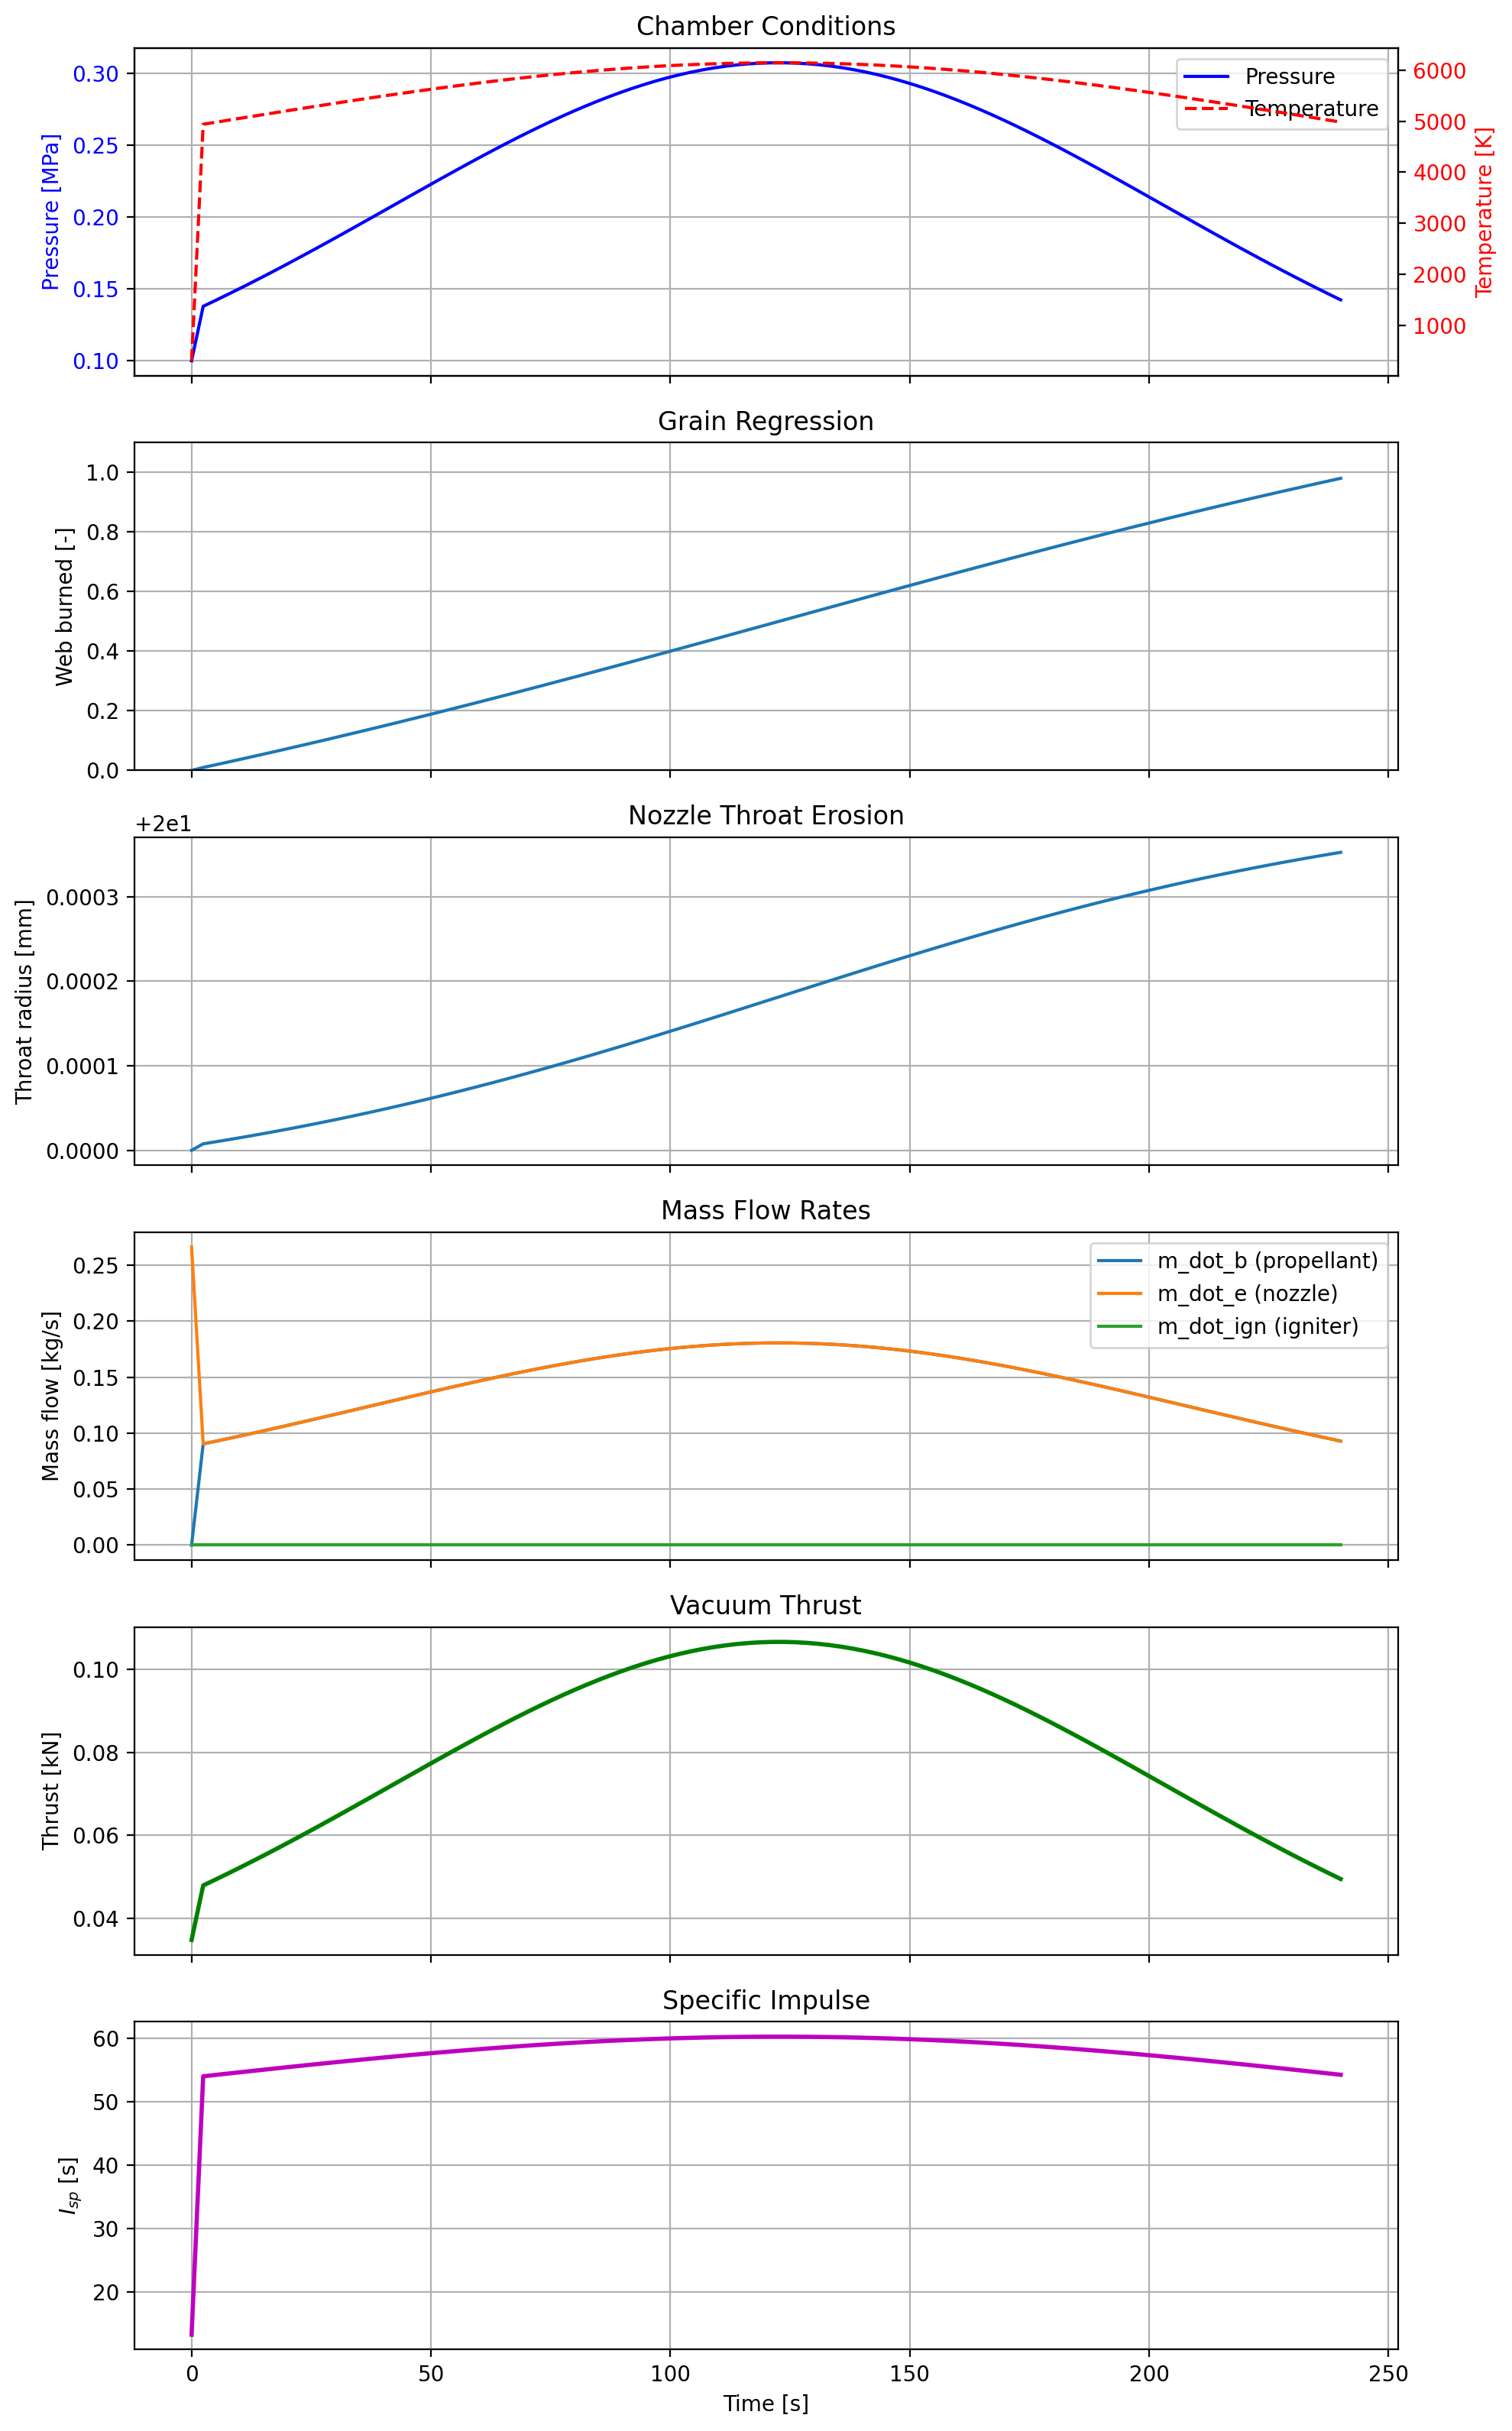

In [16]:
# Plotting
fig, axs = plt.subplots(6, 1, figsize=(10, 16), sharex=True)

# Chamber pressure
axs[0].plot(t, p/1e6, 'b-', label="Pressure")
ax2 = axs[0].twinx()
ax2.plot(t, T, 'r--', label="Temperature")
ax2.set_ylabel("Temperature [K]", color='r')
ax2.tick_params(axis='y', labelcolor='r')
axs[0].set_ylabel("Pressure [MPa]", color='b')
axs[0].tick_params(axis='y', labelcolor='b')
# Combine the legends
lines_1, labels_1 = axs[0].get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
axs[0].legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')
axs[0].grid(True)
axs[0].set_title("Chamber Conditions")

# Web regression
axs[1].plot(t, s_frac)
axs[1].set_ylabel("Web burned [-]")
axs[1].set_ylim(0, 1.1)
axs[1].grid(True)
axs[1].set_title("Grain Regression")

# Throat radius
axs[2].plot(t, r_t*1000.0)
axs[2].set_ylabel("Throat radius [mm]")
axs[2].grid(True)
axs[2].set_title("Nozzle Throat Erosion")

# Mass flows
axs[3].plot(t, m_dot_b, label="m_dot_b (propellant)")
axs[3].plot(t, m_dot_e, label="m_dot_e (nozzle)")
axs[3].plot(t, m_dot_ign, label="m_dot_ign (igniter)")
axs[3].set_ylabel("Mass flow [kg/s]")
axs[3].legend()
axs[3].grid(True)
axs[3].set_title("Mass Flow Rates")

# Thrust
axs[4].plot(t, thrust/1000.0, 'g-', linewidth=2)
axs[4].set_ylabel("Thrust [kN]")
axs[4].grid(True)
axs[4].set_title("Vacuum Thrust")

# Specific Impulse
axs[5].plot(t, Isp, 'm-', linewidth=2)
axs[5].set_ylabel("$I_{sp}$ [s]")
axs[5].set_xlabel("Time [s]")
axs[5].grid(True)
axs[5].set_title("Specific Impulse")

plt.tight_layout()
plt.show()